### Lab Machine Learning, part two: Film rekommendations system
#### Daniel Claesson, ITHS, AI-23
[link to dataset](https://grouplens.org/datasets/movielens/)
Dataset is named ml-latest.<br>
Målet med uppgiften är att ge användaren rekommendationer på filmer som kan passa.


In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')
tags = pd.read_csv('../data/tags.csv')

#### EDA
- Läser in filerna ratings, movies och tags och gör en analys av vad filerna innehåller. Innehållet i filerna finns också beskrivet i readme filen som kommer med datasetet.
- 'ratings' innehåller 33.8 miljoner filmbetyg ('rating') från 0 till 5 med steget 0.5, av 330.975 unika användare ('userId'), för 83.239 unika filmer ('movieId').
- 'movies' innehåller data för 86.532 unika filmer ('movieId'). Innehåller titel ('title') och genres ('genres'). Genres är en pipe-separated lista som genres som passar till filmen.
- 'tags' innehåller 2.328.315 användar-adderade taggar ('tag') till filmerna, användarna identifieras med ('userId'). 53.452 av filmerna har fått taggar av användarna. Dvs, cirka 30.000 filmer saknar användar-adderade taggar.
- Alla ratings och tags har också en timestamp.

In [31]:
ratings.sample(10)
#ratings.info()
#ratings['userId'].nunique()
#ratings['movieId'].nunique()
#ratings.describe()

,userId,movieId,rating,timestamp
21082306,205890,1060,4.0,939432822
12313827,121148,5502,4.0,1142844020
13269699,130454,515,2.0,839914326
3601710,35062,6667,3.0,1114930643
22084010,215410,839,5.0,1196016064
19630567,192017,750,4.5,1465519512
20520155,200252,457,5.0,838069291
30377112,297009,1644,5.0,1308105684
27944123,272646,5817,2.5,1076562950
11770112,115850,6188,3.0,1178390050


In [62]:
movies.sample(10)
#movies.info()

,movieId,title,genres
78520,262115,City of the Sun (2017),Documentary
66732,215477,Color Me You (2017),Children|Drama|Romance
13495,69755,"Lucky Texan, The (1934)",Romance|Western
45150,168574,Love Me Deadly (1973),Drama|Horror
43100,164212,Dead Herring (2012),Comedy|Drama|Mystery
81870,275105,Whoops! (1955),Comedy|Mystery
17807,92927,"Show Off, The (1926)",Comedy|Drama
65549,212703,License to Steal (1990),Action|Comedy
16362,86521,Ito: A Diary of an Urban Priest (Seitti - kilv...,Documentary
15525,81768,"Man Who Could Work Miracles, The (1936)",Comedy|Fantasy


In [37]:
tags.sample(10)
#tags.info()
#tags['movieId'].nunique()
#print(type(tags['tag'][1])) #str

,userId,movieId,tag,timestamp
649941,126357,170471,motel,1490567562
311043,62130,3186,Brittany Murphy,1657021796
731775,137062,205661,sequel,1590681915
148248,30609,783,author:Victor Hugo,1248174539
401283,77817,202155,surreal,1629932587
1090586,215490,1162,banquet,1612544371
2173840,298541,129937,liam neeson,1453902348
2221305,306765,192381,gritty,1539633640
1013697,204277,104863,zoe kazan,1528843965
793298,151122,164935,pyrenees,1570644864


(0.0, 300.0)

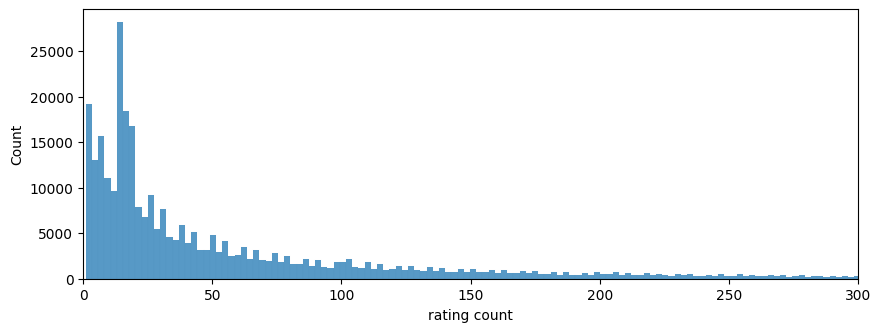

In [58]:
# analys av hur många recensioner varje user har gjort:
user_rating_count = ratings.groupby('userId')['rating'].count()
user_rating_count_df = user_rating_count.reset_index(name='rating count')
fig, ax = plt.subplots(figsize=(10,3.5))
sns.histplot(user_rating_count_df, x='rating count')
ax.set_xlim(0,300)


In [105]:
#ratings[ratings['userId'] == 126357]
ratings[ratings['userId'] == 62130]

,userId,movieId,rating,timestamp
6364967,62130,467,3.0,1663215326
6364968,62130,741,3.0,1662507230
6364969,62130,750,3.0,1655521157
6364970,62130,924,4.5,1662964251
6364971,62130,1197,3.5,1662504336
...,...,...,...,...
6365145,62130,258451,3.5,1655521502
6365146,62130,268642,2.0,1681204761
6365147,62130,270946,3.0,1681204750
6365148,62130,274053,2.0,1681204731


#### Analys "Dirty Dancing"

In [78]:
movies[movies['title'] == 'Dirty Dancing (1987)']

,movieId,title,genres
1061,1088,Dirty Dancing (1987),Drama|Musical|Romance


In [77]:
# analys av vilka användar taggar som en populär film som Dirt Dancing har fått:
tags_dd = tags[tags['movieId'] == 1088]
tags_dd

,userId,movieId,tag,timestamp
5649,1114,1088,dance,1147409630
5650,1114,1088,music,1147409627
17602,4311,1088,dancing,1367831310
22314,6407,1088,80's classic,1505669558
22315,6407,1088,coming of age,1505669556
...,...,...,...,...
2307520,327042,1088,Patrick Swayze,1166375572
2317033,328584,1088,80's classic,1391876140
2317034,328584,1088,dance,1391876127
2317035,328584,1088,dancing,1391876129


In [73]:
tags_dd['tag'].unique()

array(['dance', 'music', 'dancing', "80's classic", 'coming of age',
       'Nana viu', '1960s', 'Jennifer Grey', 'Patrick Swayze', 'romance',
       'soundtrack', 'summer camp', 'summer romance',
       'See:Dirty Dancing (1987)', 'AFI 100 (Movie Quotes)', 'overrated',
       'abortion', 'class differences', 'father daughter relationship',
       'teen movie', 'MMsWL', 'cheesy', 'chick flick', 'southern theme',
       'no one puts Baby in a corner', 'guilty pleasure', "80's",
       'musical parodies', 'classic', 'Dancing', 'bourgeois',
       'class themes', 'doctor', 'family holiday', 'holiday', 'holidays',
       'mambo', 'secret love', 'sister sister relationship',
       'unwanted pregnancy', 'Cynthia Rhodes', 'predictable',
       'social inequality', 'seen 2010', 'rich families', 'teen', 'cute',
       "1960's", '1963', 'girlie movie', 'BD-Video',
       'romance boygirl dancing', 'catskill resort', 'dance performance',
       'dancing master', 'daughter', 'hotel', 'robbery', '

In [80]:
tags_dd['tag'].value_counts().head(15)

tag
dancing           55
dance             32
coming of age     29
romance           26
Patrick Swayze    25
80's classic      15
music             15
cheesy            14
1960s             13
teen movie        11
abortion          10
Jennifer Grey      9
Dancing            9
classic            9
soundtrack         8
Name: count, dtype: int64

#### Analys "The Dark Knight"

In [81]:
movies[movies['title'] == 'Dark Knight, The (2008)']

,movieId,title,genres
12223,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX


In [83]:
tags_dk = tags[tags['movieId'] == 58559]
tags_dk

,userId,movieId,tag,timestamp
5,14,58559,Atmospheric,1311530439
6,14,58559,Batman,1311530391
7,14,58559,comic book,1311530398
8,14,58559,dark,1311530428
9,14,58559,Heath Ledger,1311530404
...,...,...,...,...
2328005,330824,58559,cinematography,1598820119
2328006,330824,58559,dark,1598819759
2328007,330824,58559,Hans Zimmer,1598820121
2328008,330824,58559,Heath Ledger,1598819766


In [98]:
tags_dk['tag'].unique()
#len(tags_dk['tag'].unique()) # 284

array(['Atmospheric', 'Batman', 'comic book', 'dark', 'Heath Ledger',
       'imdb top 250', 'Michael Caine', 'Morgan Freeman',
       'Oscar (Best Supporting Actor)', 'psychology', 'superhero',
       'vigilante', 'violence', 'action', 'Christopher Nolan',
       'Hans Zimmer', 'Heath Ledger as the Joker', 'Christian Bale',
       'atmospheric', 'cinematography', 'music',
       'Soundtrack: Hans Zimmer', 'great characters', 'great villain',
       'gritty', 'quotes', 'dark hero', 'mass surveillance', 'stylized',
       'Aaron Eckhart', 'based on a comic', 'Comic Book adaption',
       'DC Comics', 'Gary Oldman', 'Joker', 'Maggie Gyllenhaal', 'Quotes',
       'SuperVillain', 'thriller', 'too long', 'violent',
       'Library of Congress', 'National Film Registry', 'Batman (series)',
       'mask', 'To See', 'heath ledger', 'Dark hero', 'ensemble cast',
       'serial killer', 'anti-hero', 'Christopher Nolanï¼Œbatman',
       'corruption', 'organized crime', 'psychological thriller',
 

In [88]:
tags_dk['tag'].value_counts().head(20)

tag
Heath Ledger         257
Batman               243
dark                 212
superhero            202
Christian Bale       188
Christopher Nolan    178
action               160
psychology           149
Morgan Freeman       122
thriller             107
Atmospheric           79
Joker                 77
Michael Caine         77
atmospheric           74
vigilante             74
comic book            72
stylized              71
Gary Oldman           67
gritty                64
great villain         61
Name: count, dtype: int64

#### Analys "I'm not there"

In [100]:
movies[movies['title'] == "I'm Not There (2007)"]

,movieId,title,genres
11979,56286,I'm Not There (2007),Drama


In [102]:
tags_ImNotThere = tags[tags['movieId'] == 56286]
tags_ImNotThere

,userId,movieId,tag,timestamp
36391,7716,56286,androgyny,1226940972
99087,18266,56286,Bob Dylan,1675261319
136396,27227,56286,confusing,1307757786
136397,27227,56286,David Cross,1307757790
136398,27227,56286,surreal,1307757800
...,...,...,...,...
2086502,275825,56286,cate blanchett,1444512562
2222140,307012,56286,perrot library,1255144657
2282571,319758,56286,biography,1577661193
2282572,319758,56286,multiple storylines,1577661176


In [103]:
tags_ImNotThere['tag'].value_counts().head(20)

tag
Bob Dylan           12
surreal              7
surrealism           6
Mindfuck             6
confusing            6
music                5
androgyny            5
cate blanchett       5
Cate Blanchett       4
1960s                4
allen ginsberg       3
Christian Bale       2
bob dylan            2
horseback riding     2
faked death          2
actor                2
R                    2
David Cross          2
biography            2
reporter             2
Name: count, dtype: int64

#### Mest populära filmerna

#### EDA slutsatser, summering och tankar
- Syftet med laben är att rekommendera filmer.
- Rekommendationerna ska vara personliga och anpassade efter användarens preferenser, denna approach liknar mest "collaborative filtering". Alternativa kan rekommendationerna vara baserade på tex en film som indata, och algoritmen hittar sedan filmer som liknar den filmen (denna approach liknar mest "content filtering".)
- I filen 'ratings' finns kolumnen 'tags', som användare har angett. Den informationen kommer vara essentiell, eftersom baserat på den informationen så bör det gå att kategorisera eller klustra användare. Informationen avslöjar användarens preferenser. Ju fler ratings som en användare har gett, desto mer känner man ju den användaren och det borde bli enklare att ge rekommendationer. I både fallet med "collaborative filtering" eller "content filtering", så är denna informationen essentiell.
- Rekomenderingsalgoritmen bör (troligen) helst i första hand rekommendera 'populära' filmer. Dvs filmer som har många recensioner och höga betyg (men som inte blivit recenserad av användaren). Men för optimal prestanda måste den också kunna ge förslag på mindre kända filmer, som kanske inte har många recensioner men ett stadigt högt betyg eller som uppfyller användarens nischade smak.
- Baserat på att det är så lite information i 'genre' kolumnen, så kommer användar-taggarna bli avgörande för att kunna ge bra rekommendationer. Detta eftersom de ger en djupare insikt i vad varje film egentligen handlar om, vilka skådespelare som spelar osv. Dessutom, vissa taggar är återkommande, vilket gör att man kan rangordna taggar utefter hur ofta de förekommer.
    - Ett exempel på att användartaggarna kommer vara avgörande är filmen The Dark Knight. I 'movies' datan så anges endast "Action|Crime|Drama|IMAX" i 'genre'. Det är väldigt begränsad information och säger endast på en väldigt hög nivå vad filmen handlar om (tex kan man utesluta kommedi eller western). När man adderar användar taggarna så får man information såsom 'batman', 'Heath Ledger', 'super hero, 'joker' med mera. Denna informationen är också omfattande, det finns 284 unika tags som tillsammans ger mycket mer kött på benen vad filmen handlar om.
    - Man skulle kunna sammanfatta det med att taggarna ger en stor mängd information, liknande Features i analys vi gjort tidigare i ML kursen. Men Features'arna kommer vara unika för varje film, men givetvis kan samma tagg återkomma i olika filmer. Alla Batman filmer har ju troligen taggen 'batman'.
    

#### Teori och undersökning på internet
- Sökte upp information om recommender systems på nätet. I [knowledgehut](https://www.knowledgehut.com/blog/data-science/movie-recommendation-system) kan man läsa om olika typer an recommender systems. Även hos [algolia](https://www.algolia.com/blog/ai/the-anatomy-of-high-performance-recommender-systems-part-iv/?utm_source=google&utm_medium=paid_search&utm_campaign=rl_emea_search_dstalg_nb_dynamic&utm_content=blog_ai_dynamic&utm_term=&utm_region=emea&utm_model=nonbrand&utm_ag=rl&utm_camp_parent=slg&utm_2nd_camp=dstalg&_bt=677640514505&_bm=&_bn=g&gad_source=1&gclid=CjwKCAjwzN-vBhAkEiwAYiO7oMYf76up9PTTg7tuoqBRKsJyAohMi_ZiP-Yow0JtYB0T7T1e8meiEhoCfVMQAvD_BwE).<br>
- Det finns två huvudsakliga approacher till recommendersystem:
    - Content filtering: denna metoden går ut på att hitta likheter mellan en film (som användaren anger) och andra filmer.
    - Collaborative filtering: denna metoden går ut på att baserat på användarens egna recensioner, hitta andra användare som har liknande smak, och på så sätt identifiera filmer som  är intressanta.
- Eftersom taggarna är essentiella för uppdraget, så behöver vi ha en metod som kan jämföra taggar för olika filmer och kunna avgöra om taggarna liknar varandra eller om de skiljer sig avsevärt. En sådan teknik är "cosine similarity".